## IMPORT STATEMENTS

In [547]:
import pandas as pd
import numpy as np
import nltk
import re 
import os
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import LancasterStemmer
from collections import defaultdict
import pickle
# import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
import tensorflow_hub as hub
import numpy as np
from scipy.spatial.distance import cosine
from itertools import chain
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## STOP WORDS INITIALIZATION

In [548]:
stop_words = set()
languages = ['english','hindi']
for lang in languages:
    with open(lang+".txt",'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.rstrip()
            stop_words.add(line)

print(stop_words)

{'become', 'four', 'hers', 'abroad', 'वे', 'act', 'haven', 'somehow', 'way', 'apparently', 'pm', 'nos', 'doing', 'readily', 'kz', 'ao', 'approximately', 'ml', 'पे', 'into', 'tn', 'eg', "we'll", 'faces', 'opening', 'thatve', 'thered', 'hardly', 'इन्हें', 'backward', 'front', 'members', "can't", 'pmid', 'घर', 'msie', 'opened', 'her', 'गया', 'जब', 'संग', 'corresponding', 'wants', 'text', 'says', 'tg', 'welcome', 'across', 'long', 'various', 'hk', 'rooms', 'इसके', 'successfully', 'strongly', 'they', 'किसे', 'thinks', 'somewhere', 'सकते', 'es', 'unlike', 'za', 'thereve', 'aint', 'lately', 'cd', 'sm', 'fewer', 'td', 'hereupon', 'computer', 'downed', 'state', 'necessarily', "c's", 'mv', 'where', 'need', 'uz', 'hundred', 'yours', 'described', 'two', "hasn't", 'meanwhile', 'farther', 'h', 'k', 'myse”', "who's", 'w', 'pp', 'कुल', 'mrs', 'anything', 'small', 'there', 'please', 'half', 'is', 'selves', 'evermore', 'mq', 'जिन', 'pages', 'proud', 'होती', 'इसकी', 'far', 'उसके', 'yourself', 'o', 'si', 

## BASEWORDS INITILIAZATION

In [549]:
base_tweet = list()
base_tweet.append("India delivers stinging blow to Pakistan across the LoC #ModiPunishesPak https://t.co/WNc0D3u2QI")
# base_tweet.append("Pushing forward India's historical ethos of giving refuge to the persecuted, Modi Govt passed the Citizenship Amendment Bill. Persecuted refugees from Pakistan, Afghanistan, and Bangladesh will be given Indian citizenship. #IndiaSupportsCAA")
# base_tweet.append("#IndiaSupportsCAA Citizenship Amendment Bill does justice to those who were denied justice for decades! It gives rights to the disempowered &amp; does not affect the rights of Indian citizens at all")
print(base_tweet[0])

India delivers stinging blow to Pakistan across the LoC #ModiPunishesPak https://t.co/WNc0D3u2QI


## DATA PREPROCESSING

In [550]:
def data_cleaning(tweet_array,tweet_id,length):
  # using nltk twitter tokenizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lancaster=LancasterStemmer()
    processed_review=[]
    mapping = dict()
    single_review = ""
    for index in range(0,length):
        single_review = tweet_array[index]
        # remove html tags
        single_review = re.sub('<.*?>',' ',single_review)
        # remove single characters
        single_review = re.sub('\s+[a-zA-Z]\s+',' ', single_review)
        # remove multiple spaces 
        single_review = re.sub('\s+',' ', single_review)
        # use twitter tokenizer
        tk = TweetTokenizer()
        word_tokens = tk.tokenize(single_review)
        lemmatized_sentence = " ".join(lemmatizer.lemmatize(token) for token in word_tokens if token not in stop_words)
        processed_review.append(lemmatized_sentence)
        mapping[tweet_id[index]]=single_review

    
    return processed_review, mapping

In [551]:
# This function takes tweets as input and preprocess it consider tweet id
def data_preprocessing(df):
  # finding different languages and considering only english and hindi
  print("unique languages are",df.language.unique())
  en_df = df.loc[df['language']=='en']
  hi_df = df.loc[df['language']=='hi']
  print("english tweets shape is",en_df.shape)
  print("hindi tweets shape is",hi_df.shape)
  english_content = np.array(en_df.content)
  hindi_content = np.array(hi_df.content)
  english_tweet_id = np.array(en_df.tweet_id)
  hindi_tweet_id = np.array(hi_df.tweet_id)
  length1 = en_df.shape[0]
  length2 = hi_df.shape[0]
  english_tweets, en_id_content = data_cleaning(english_content,english_tweet_id, length1)
  hindi_tweets, hi_id_content  = data_cleaning(hindi_content,hindi_tweet_id,length2)
  return english_tweets, hindi_tweets, en_id_content, hi_id_content


In [552]:
india_propaganda = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/hash_tag_csv/ModiPunishesPak.csv'
df = pd.read_csv(india_propaganda)
english_tweets, hindi_tweets, en_mapping, hi_mapping = data_preprocessing(df)

unique languages are ['und' 'en' 'tl' 'hi' 'in' 'et' 'ur' 'de' 'es' 'ht' 'bn' 'ne' 'mr' 'nl'
 'da' 'pt' 'ta' 'cs' 'kn' 'hu' 'it' 'gu' 'cy' 'te' 'eu' 'ca' 'fi' 'ml'
 'is' 'pl' 'lv' 'fr' 'tr' 'ro' 'sl' 'lt' 'sv' 'no' 'vi' 'or' 'ja' 'ar']
english tweets shape is (24859, 9)
hindi tweets shape is (12949, 9)


In [553]:
print(len(en_mapping))

24859


In [554]:
preprocessed_tweets = list()
t, id = data_cleaning(base_tweet,[1],len(base_tweet))
print(t)

['India delivers stinging blow Pakistan LoC #ModiPunishesPak https://t.co/WNc0D3u2QI']


In [555]:
print(id)

{1: 'India delivers stinging blow to Pakistan across the LoC #ModiPunishesPak https://t.co/WNc0D3u2QI'}


## USER DATA LOADING

In [556]:
party_url = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/user_tweets/user_data.csv'
df_party_names = pd.read_csv(party_url)
user_details_url = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/user_tweets/user_details.csv'
df_user_data = pd.read_csv(user_details_url)

In [557]:
df_party_names.head()

,Unnamed: 0,verified,location,id,url,public_metrics,protected,party,username,name,created_at,description
0,0,True,"Punjab, India",3153134184,NaN,"{'followers_count': 58375, 'following_count': ...",False,BJP,sunilkjakhar,Sunil Jakhar,2015-04-13T16:14:06.000Z,NaN
1,1,True,NEW DELHI,45795876,NaN,"{'followers_count': 21332, 'following_count': ...",False,BJP,rpsinghkhalsa,RP Singh National Spokesperson BJP,2009-06-09T08:33:22.000Z,"Advertising Professional.\nPatron, Gali Pathsh..."
2,2,True,Dehradun,1297926962,https://t.co/SkirgMiB7f,"{'followers_count': 1907, 'following_count': 2...",False,BJP,bjpnareshbansal,Naresh Bansal,2013-03-25T06:31:52.000Z,Member of Parliament Rajya Sabha | Ex. General...
3,3,True,pokhari chamoli uttarakhand,2692838006,https://t.co/9j75o0vuWo,"{'followers_count': 5481, 'following_count': 3...",False,BJP,mahendrabhatbjp,Mahendra Bhatt MLA,2014-07-30T13:02:25.000Z,महेंद्र भट्ट विधायक बद्रीनाथ विधानसभा उत्तराखं...
4,4,True,"Yamkeshwar, India",1028186624218288128,https://t.co/SxS5stdGzU,"{'followers_count': 2602, 'following_count': 1...",False,BJP,RituKhanduriBJP,Ritu Khanduri Bhushan,2018-08-11T07:49:28.000Z,Official Account of Smt. Ritu Khanduri Bhushan...


In [558]:
df_user_data.head()

,username,id,displayname,followersCount,friendsCount,location
0,BJP4JnK,1864685238,BJP Jammu & Kashmir,86433,222,Jammu & Kashmir
1,GulabMatiala,2922933098,Gulab Singh,38727,716,"New Delhi, India"
2,guptaravinder71,2204739805,Ravinder Gupta 🇮🇳,23358,1234,"Karol Bagh, New Delhi"
3,MaheishGirri,425973946,Maheish Girri,133913,657,"New Delhi, India"
4,shweta_shalini,2366619296,Shweta Shalini,22684,374,Mumbai


## PERFORM EMBEDDING

In [559]:
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
# model = hub.load(module_url)

In [560]:
# !pip install sentence-transformers

In [561]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [562]:
tweet_embeddings = sbert_model.encode(english_tweets)
print(tweet_embeddings.shape)

(24859, 768)


In [563]:
base_embeddings = sbert_model.encode(t)
print(base_embeddings.shape)

(1, 768)


## CREATE MAPPING BETWEEN TWEET_ID AND EMBEDDING

In [564]:
# This function creates mapping between embedding and tweet id
from collections import defaultdict
def reverse_mapping(tweet_embeddings,en_mapping):
  rev_map = defaultdict(list)
  index = 0
  for tweet_id in en_mapping.keys():
    tupple = tuple(tweet_embeddings[index])
    rev_map[tupple].append(tweet_id)
    index = index+1 
  print(index)
  return rev_map

In [565]:
rev_map = reverse_mapping(tweet_embeddings,en_mapping)
print(len(rev_map))

24859
23489


## Cosine similarity

In [566]:
from sklearn.metrics.pairwise import cosine_similarity
def similarity(base_embeddings,tweet_embeddings):
  temp_np_array = np.zeros((len(tweet_embeddings),768))
  i = 0
  for k in tweet_embeddings:
    k = np.array(k)
    temp_np_array[i]=k
    i=i+1
  c_sim=cosine_similarity(base_embeddings,temp_np_array)
  return c_sim

In [567]:
sim=similarity(base_embeddings,rev_map.keys())
print(sim.shape)

(1, 23489)


In [568]:
sim_list = sim.tolist()

In [569]:
f_list = sim_list[0]
print(len(f_list))
result = list()
# print(len(tweet_embeddings))
k_list = list(rev_map.keys())
for index in range(len(f_list)):
  if f_list[index] >= 0.80:
      result.append(k_list[index])


print(len(result))

23489
853


In [570]:
c_p_tweet = list()
for r in result:
  tweet_id = rev_map[tuple(r)]
  for t in tweet_id:
    c_p_tweet.append(t)
    print(en_mapping[t])
print(len(c_p_tweet))

Gooter gooter gooter!!!! https://t.co/mFzZyKmKtY #ModiPunishesPak #Indians #India
Now Government of India responding proactively against Pakistan. #ModiPunishesPak https://t.co/YpGOtdZuQe
https://t.co/yLTMdsdz4w great Atif Aslam #AtifAslam #indianMedia #Slapped #ModiPunishesPak
brace it Mother ship of terrorism #India #ModisInnovativeDiplomacy #ModiPunishesPak #ModiIsolatepak Bollywood Morons
Pak High Commissioner Abdul Basit rubbishes Indian surgical strike claims https://t.co/dSBcwMemX2 #ModiPunishesPak
#Modi #Dussehra arrow: Will decimate #terror, its backers-https://t.co/duCwYzkBJl #ModiPunishesPak #terrorstatepak #Indians #Pakistan #news https://t.co/fzs7xYMtxU
Advantage #IndiaStrikesBack Vis #Pakistan ! - #Vikatakavi Link : https://t.co/4zlP8FYjgr #SurgicalStrikes #IndianArmy #ModiPunishesPak https://t.co/bNXLdQFQhj
This Is Prove Of #India First #SurgicalStrike in Let Terror Camps #Pakistan #DovalModiStrikes #BackArmyEndPolitics #ModiPunishesPak https://t.co/UJzWQCq8hx
@ArvindKej

In [571]:
print("total number of copy pasted",len(c_p_tweet))

total number of copy pasted 908


In [572]:
new_df = df.loc[df['tweet_id'].isin(c_p_tweet)]

In [573]:
new_df[['date', 'time']] = new_df['date'].str.split('T', 1, expand=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [574]:
copy_counts=dict(new_df.groupby('date').groups)
dates=[k for k in copy_counts.keys()]
counts=[len(v) for k,v in copy_counts.items()]
cum_counts=counts.copy()
for i in range(1,len(cum_counts)):
  cum_counts[i]+=cum_counts[i-1]

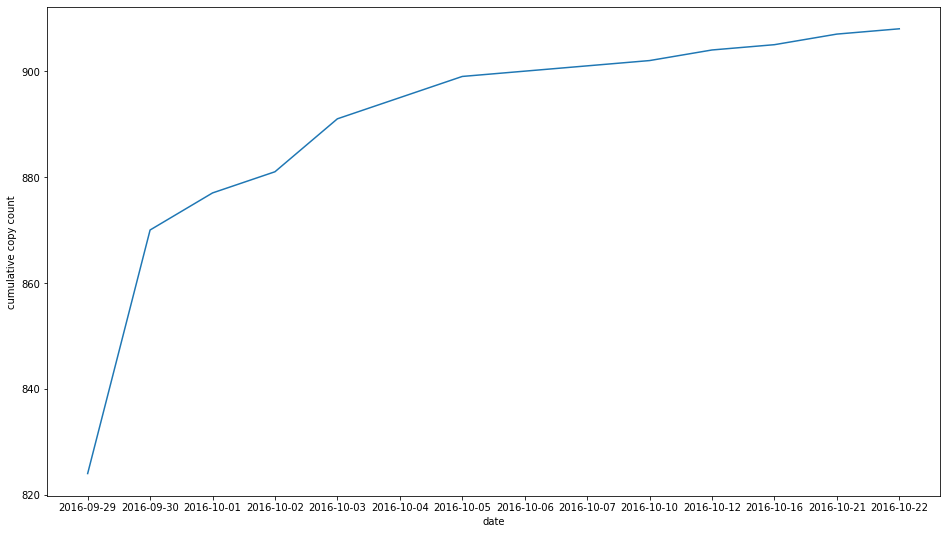

In [575]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(dates,cum_counts)
plt.xlabel('date')
plt.ylabel('cumulative copy count')
plt.show()

In [576]:
use1=df.loc[df['tweet_id'].isin(c_p_tweet)]
use2=pd.merge(use1,df_party_names,left_on='user_name',right_on='username')
use2.head()

,tweet_id,user_name,date,content,language,reply_count,retweet_count,like_count,hashtags,Unnamed: 0,...,location,id,url,public_metrics,protected,party,username,name,created_at,description
0,781522012875272192,naqvimukhtar,2016-09-29T15:52:22+00:00,India is proud of PM @narendramodi for isolat...,en,8,140,492,['ModiPunishesPak'],233,...,India,287156977,NaN,"{'followers_count': 1269739, 'following_count'...",False,BJP,naqvimukhtar,Mukhtar Abbas Naqvi,2011-04-24T12:36:23.000Z,"Mukhtar Abbas Naqvi, Union Cabinet Minister of..."
1,781486457638756352,girirajsinghbjp,2016-09-29T13:31:05+00:00,PM @narendramodi ji knew from the very first d...,en,19,369,518,"['ModiPunishesPak', 'IndiaStrikesBack']",174,...,"Bihar, India",1642669674,https://t.co/Tc6jiFmjb9,"{'followers_count': 1661070, 'following_count'...",False,BJP,girirajsinghbjp,Shandilya Giriraj Singh,2013-08-03T12:03:49.000Z,| Nationalist | BJP Karyakarta | MP for Begusa...
2,781436887206469632,BJP4JnK,2016-09-29T10:14:06+00:00,India delivers a stinging blow to Pakistan acr...,en,0,5,15,['ModiPunishesPak'],112,...,Jammu & Kashmir,1864685238,https://t.co/xqcf4hdeTZ,"{'followers_count': 86430, 'following_count': ...",False,BJP,BJP4JnK,BJP Jammu & Kashmir,2013-09-14T19:21:16.000Z,Official Twitter Account of Bharatiya Janata P...
3,781435861393141760,BJP4Goa,2016-09-29T10:10:02+00:00,India delivers a stinging blow to Pakistan acr...,en,0,0,2,['ModiPunishesPak'],40,...,NaN,758216347486720000,https://t.co/VuEjuLf3Js,"{'followers_count': 69918, 'following_count': ...",False,BJP,BJP4Goa,BJP Goa,2016-07-27T08:23:59.000Z,Official BJP Goa state twitter account
4,781435861393141760,BJP4Goa,2016-09-29T10:10:02+00:00,India delivers a stinging blow to Pakistan acr...,en,0,0,2,['ModiPunishesPak'],106,...,NaN,758216347486720000,https://t.co/VuEjuLf3Js,"{'followers_count': 69918, 'following_count': ...",False,BJP,BJP4Goa,BJP Goa,2016-07-27T08:23:59.000Z,Official BJP Goa state twitter account


In [577]:
print(dates)

['2016-09-29', '2016-09-30', '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07', '2016-10-10', '2016-10-12', '2016-10-16', '2016-10-21', '2016-10-22']
